In [2]:
!pip install fuzzywuzzy
#!pip install tensorflow==2.17.1

In [3]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from fuzzywuzzy import process
import pickle

print(tf.__version__)

2.17.1


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))


lemmatizer = WordNetLemmatizer()

def remove_suffix(word):
    suffixes = ['nya', 'ku', 'mu']
    for suffix in suffixes:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

# Fungsi untuk preprocessing lengkap
def preprocess_pipeline(text):
    words = nltk.word_tokenize(text.lower())  # Tokenize dan lowercase
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize
    words = [remove_suffix(word) for word in words if word not in stop_words]  # Hapus akhiran dan stopwords
    return ' '.join(words)

# Load the balanced JSON intents
with open('balanced_dataPajak.json') as file:
    data = json.load(file)

# Preprocess patterns and tags
patterns = []
tags = []
responses = {}

for intent in data['intents']:
    for pattern in intent['patterns']:
        patterns.append(preprocess_pipeline(pattern))  # Preprocess pattern
        tags.append(intent['tag'])
    responses[intent['tag']] = intent['responses']

from sklearn.model_selection import train_test_split
# Split the data into 70% train and 30% dev set
train_patterns, dev_patterns, train_tags, dev_tags = train_test_split(
    patterns, tags, test_size=0.3, random_state=42
)

# Tokenizer for text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_patterns)
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index

# Convert train and dev patterns to sequences and pad them
train_sequences = tokenizer.texts_to_sequences(train_patterns)
dev_sequences = tokenizer.texts_to_sequences(dev_patterns)

max_len = max(len(seq) for seq in train_sequences)
with open('config.json', 'w') as f:
    json.dump({'MAX_LEN': max_len}, f)


train_padded_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post')
dev_padded_sequences = pad_sequences(dev_sequences, maxlen=max_len, padding='post')

# Encode tags
tag_list = list(set(tags))  # Unique tags
tag_index = {tag: i for i, tag in enumerate(tag_list)}

train_tags_encoded = np.array([tag_index[tag] for tag in train_tags])
dev_tags_encoded = np.array([tag_index[tag] for tag in dev_tags])


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(max_len)

70


In [ ]:
# One-hot encode tags
num_tags = len(tag_list)
train_tags_one_hot = tf.keras.utils.to_categorical(train_tags_encoded, num_tags)
dev_tags_one_hot = tf.keras.utils.to_categorical(dev_tags_encoded, num_tags)

# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (max_len,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    #tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_tags, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 70, 64)              │          99,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 70, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 70, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 666)                 │          85,914 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 293,018 (1.12 MB)

 Trainable params: 293,018 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip install pydot

In [ ]:
!pip install graphviz

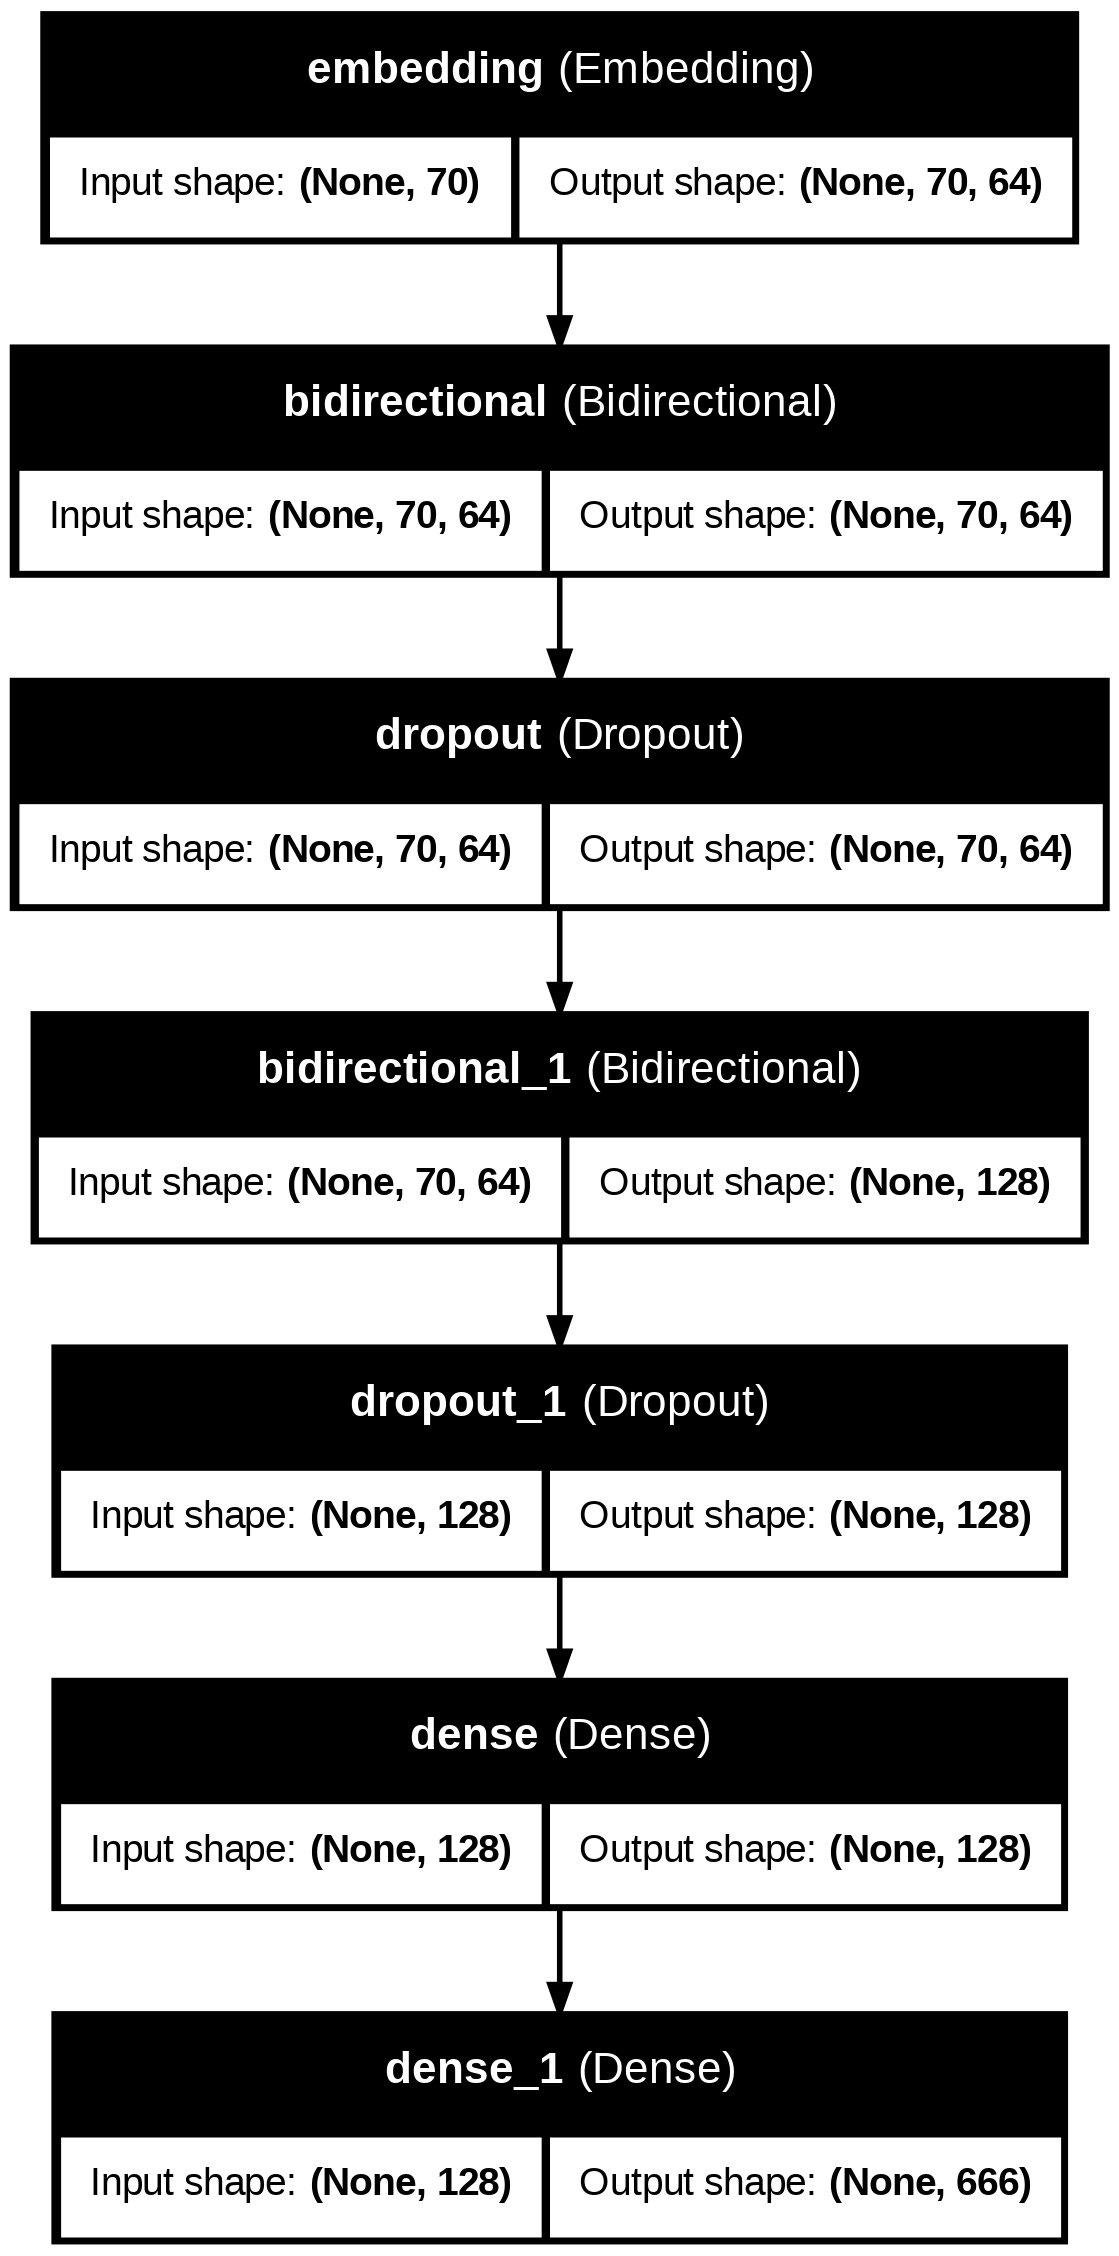

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:

# Create TensorFlow Dataset for optimized pipeline
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_padded_sequences, train_tags_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((dev_padded_sequences, dev_tags_one_hot))

# Optimize dataset pipeline
train_dataset_final = (
    train_dataset
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .cache()
    .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

test_dataset_final = (
    test_dataset
    .cache()
    .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Adjust model training to use optimized datasets
history = model.fit(
    train_dataset_final,
    validation_data=test_dataset_final,
    epochs=50,
)


Epoch 1/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 56s 180ms/step - accuracy: 0.0027 - loss: 6.4708 - val_accuracy: 0.0034 - val_loss: 5.9551
Epoch 2/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 37s 159ms/step - accuracy: 0.0078 - loss: 5.6252 - val_accuracy: 0.0178 - val_loss: 5.0805
Epoch 3/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.0245 - loss: 4.9418 - val_accuracy: 0.0444 - val_loss: 4.5123
Epoch 4/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 37s 158ms/step - accuracy: 0.0495 - loss: 4.4571 - val_accuracy: 0.1245 - val_loss: 3.8769
Epoch 5/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 38s 164ms/step - accuracy: 0.0872 - loss: 3.9304 - val_accuracy: 0.1786 - val_loss: 3.2772
Epoch 6/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - accuracy: 0.1463 - loss: 3.4149 - val_accuracy: 0.2659 - val_loss: 2.7634
Epoch 7/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 37s 160ms/step - accuracy: 0.1937 - loss: 3.0006 - val_accuracy: 0.3672 - val_loss: 2.3527
Epoch 8/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.2479 - loss: 2

In [11]:
# Evaluate the model on validation set
!val_loss, val_accuracy = model.evaluate(train_dataset_final, validation_data)
!print(f"Validation Loss: {val_loss}")
!print(f"Validation Accuracy: {val_accuracy}")

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `val_loss, val_accuracy = model.evaluate(train_dataset_final, validation_data)'
/bin/bash: -c: line 1: syntax error near unexpected token `f"Validation Loss: {val_loss}"'
/bin/bash: -c: line 1: `print(f"Validation Loss: {val_loss}")'
/bin/bash: -c: line 1: syntax error near unexpected token `f"Validation Accuracy: {val_accuracy}"'
/bin/bash: -c: line 1: `print(f"Validation Accuracy: {val_accuracy}")'


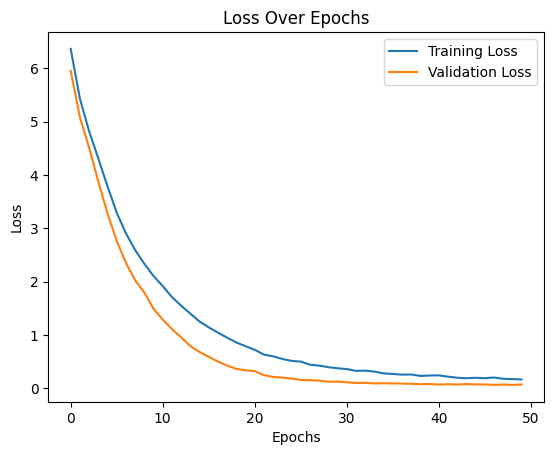

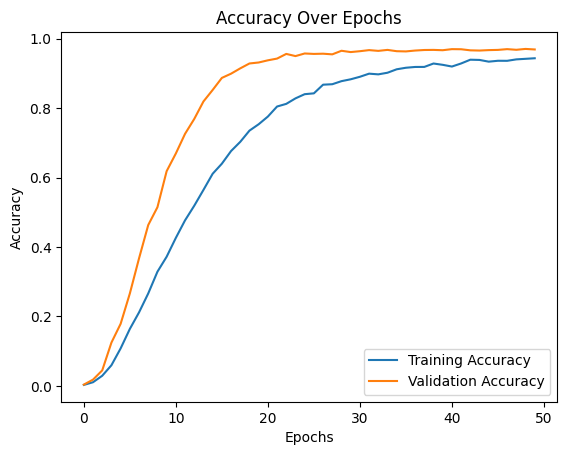

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# New Section

In [13]:
from fuzzywuzzy import fuzz
# Fuzzy Matching untuk menemukan pola terbaik
def find_best_match(user_input, patterns, threshold=80):
    match = process.extractOne(user_input, patterns)
    if match and match[1] > threshold:
        return match[0]
    return None
# Fungsi untuk memberikan saran
def suggest_similar(user_input, patterns):
    suggestions = process.extract(user_input, patterns, limit=3, scorer=fuzz.partial_ratio)
    return [suggestion[0] for suggestion in suggestions if suggestion[1] > 60]


In [1]:
def chatbot_response(user_input):
    # Preprocess input
    processed_input = preprocess_pipeline(user_input)

    # Fuzzy match
    best_match = find_best_match(processed_input, patterns)

    if best_match:
        # Temukan tag berdasarkan pola yang cocok
        matched_index = patterns.index(best_match)
        predicted_tag = tags[matched_index]
        return random.choice(responses[predicted_tag])
    else:
        # Jika tidak ada kecocokan, beri saran
        suggestions = suggest_similar(processed_input, patterns)
        if suggestions:
            return f"Maaf, saya tidak memahami maksud Anda. Apakah yang Anda maksud: {', '.join(suggestions)}?"
        else:
            return "Maaf, saya tidak memahami maksud Anda. Bisakah Anda menjelaskan lebih lanjut?"

# Uji Chatbot
while True:
    user_input = input("You: ")
    if user_input.lower() == "quit":
        break
    print("Bot:", chatbot_response(user_input))


You: hi


NameError: name 'preprocess_pipeline' is not defined

In [17]:
model.save("lstm_model.h5")  # Save the entire model (architecture + weights)
model.save_weights("lstm_model.weights.h5")  # Save only the weights with the correct filename
print("Model berhasil disimpan ke 'lstm_model'.")

Model berhasil disimpan ke 'lstm_model'.
